In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt, rcParams
from matplotlib_inline.backend_inline import set_matplotlib_formats

rcParams["figure.figsize"] = (8, 5)
rcParams["figure.dpi"] = 100
set_matplotlib_formats("retina")
plt.style.use("seaborn")

In [2]:
def load_npz(filename):
    array_dict = np.load(os.path.join(directory, filename))
    return np.array([array_dict[key] for key in array_dict], dtype=object)

In [3]:
df = pd.read_csv("data/train_data_binary.csv")
pos_mask = df.label == 1
neg_mask = df.label == 0

# Likelihood

In [4]:
directory = "output/experiment1"
filenames = list(
    filter(lambda filename: filename.endswith("likelihood.npz"), os.listdir(directory))
)
filenames

['rand_masked_likelihood.npz',
 'masked_likelihood.npz',
 'no_masked_likelihood.npz']

In [5]:
likelihoods = {
    filename.split('.')[0]: load_npz(filename)
    for filename in filenames
}

In [6]:
def get_average_likelihood(probs, mask):
    likelihoods = [np.mean(np.exp(sequence)) for sequence in probs[mask]]
    return np.mean(likelihoods)

In [15]:
pos_likelihoods = {filename: get_average_likelihood(probs, pos_mask) for filename, probs in likelihoods.items()}
neg_likelihoods = {filename: get_average_likelihood(probs, neg_mask) for filename, probs in likelihoods.items()}

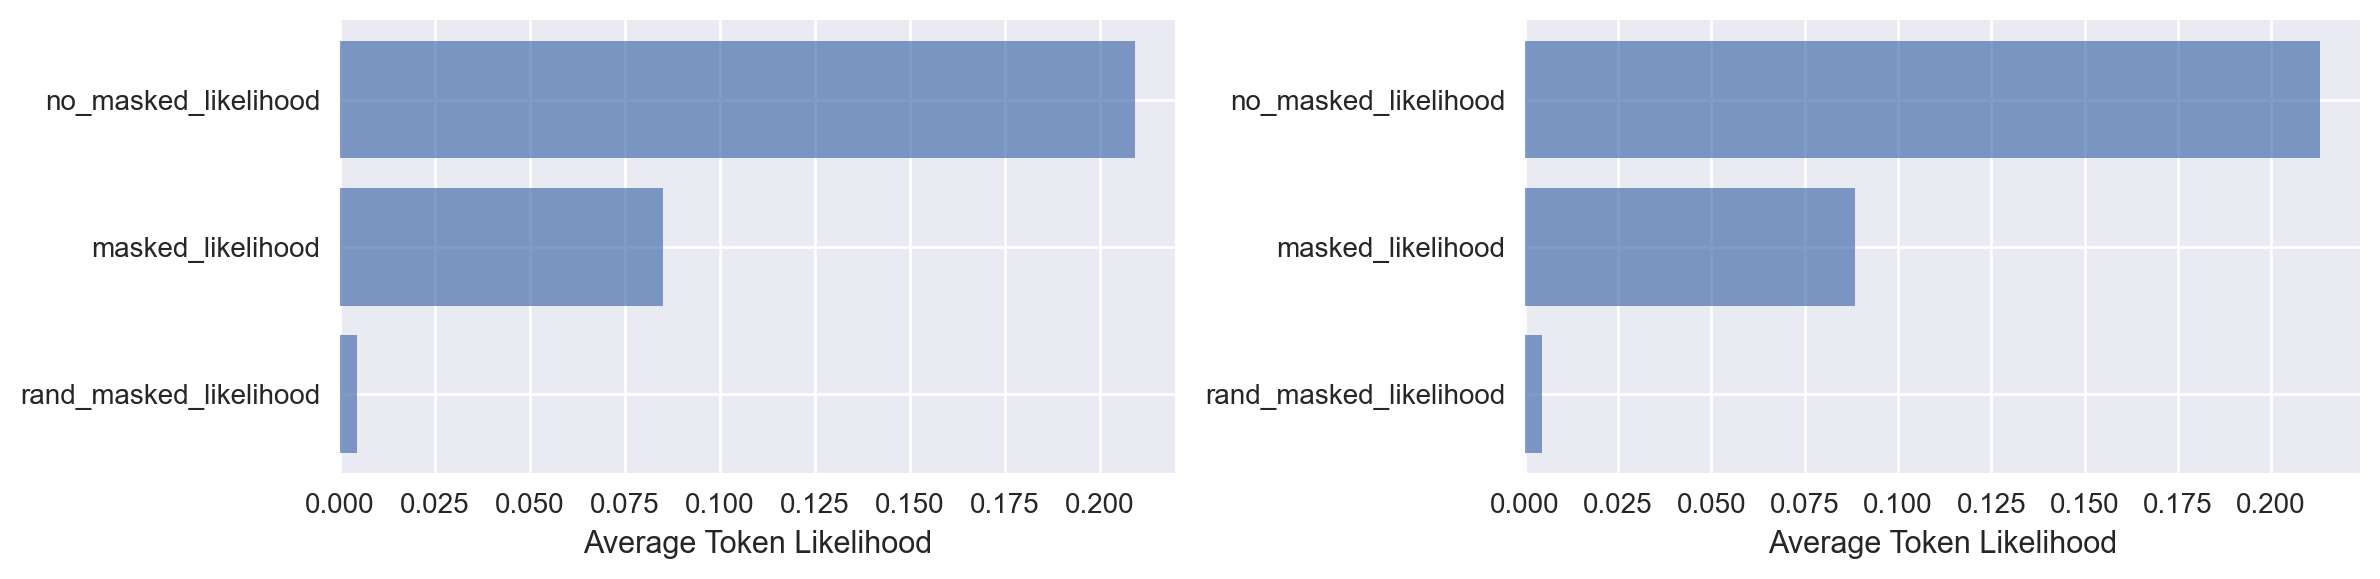

In [18]:
plt.figure(figsize=(12,3))

widths = pos_likelihoods.values()
# labels = ['No Mask', 'Correlation Mask', 'Random Mask']
labels = list(pos_likelihoods.keys())

plt.subplot(121)
plt.barh(labels, widths, alpha=0.7)

plt.xlabel('Average Token Likelihood')


widths = neg_likelihoods.values()
# labels = ['No Mask', 'Correlation Mask', 'Random Mask']
labels = list(neg_likelihoods.keys())

plt.subplot(122)
plt.barh(labels, widths, alpha=0.7)

plt.xlabel('Average Token Likelihood')

plt.tight_layout()
plt.show()

# KL Divergence

In [4]:
directory = "output/experiment1"
filenames = list(
    filter(lambda filename: filename.endswith("probs.npz"), os.listdir(directory))
)
filenames

['masked_log_probs.npz',
 'no_masked_log_probs.npz',
 'rand_masked_log_probs.npz']

In [5]:
def kl_div(P, Q):
    return np.sum(P * np.log(P / Q))

In [6]:
log_probs = {
    filename.split('.')[0]: load_npz(filename)
    for filename in filenames
}

In [7]:
probs = np.concatenate(
    (
        log_probs["masked_log_probs"].squeeze(),
        log_probs["no_masked_log_probs"].squeeze(),
    )
)
probs.shape

(13840, 50257)

In [8]:
pca = PCA(n_components=2)
Xhat = pca.fit_transform(probs)

In [21]:
c = np.concatenate((pos_mask.astype(int), pos_mask.astype(int) + 2))
c.shape

(13840,)

In [26]:
pos_avg_w = (c == 1)
pos_avg_wout = (c == 3)
neg_avg_w = (c == 0)
neg_avg_wout = (c == 2)

In [30]:
points = np.array([
    Xhat[pos_avg_w].mean(axis=0),
    Xhat[pos_avg_wout].mean(axis=0),
    Xhat[neg_avg_w].mean(axis=0),
    Xhat[neg_avg_wout].mean(axis=0),
])

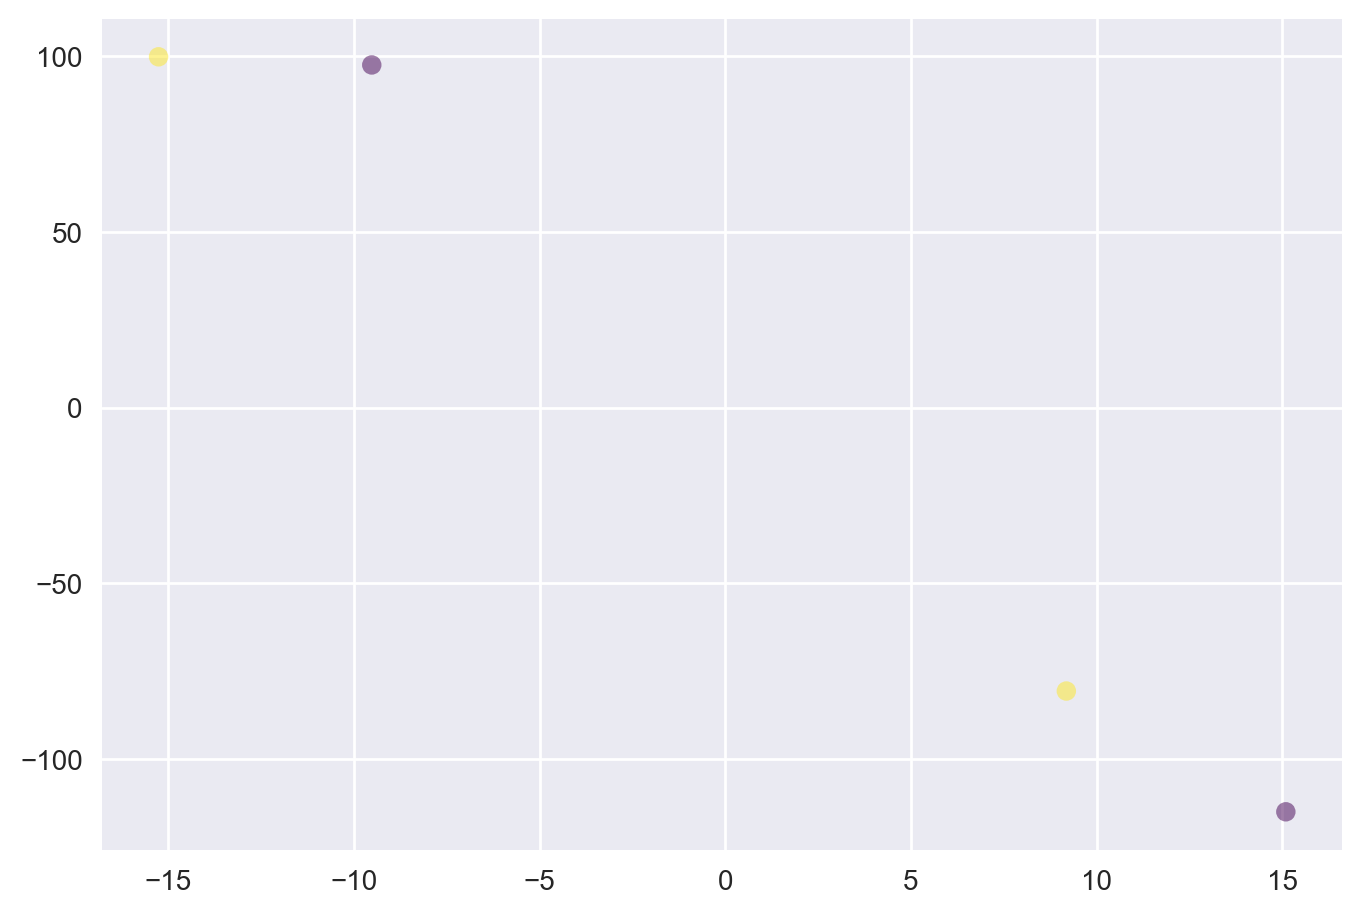

In [33]:
plt.scatter(*points.T, alpha=0.5, edgecolors='None', c=[0,0,1,1], cmap="viridis")
plt.show()

In [ ]:
pos_divs = [
    kl_div(
        np.exp(masked[0].astype(float)),
        np.exp(no_masked[0].astype(float)),
    )
    for masked, no_masked in zip(
        log_probs["masked_log_probs"][pos_mask], log_probs["no_masked_log_probs"][pos_mask]
    )
]

neg_divs = [
    kl_div(
        np.exp(masked[0].astype(float)),
        np.exp(no_masked[0].astype(float)),
    )
    for masked, no_masked in zip(
        log_probs["masked_log_probs"][neg_mask], log_probs["no_masked_log_probs"][neg_mask]
    )
]

In [12]:
pos_divs = [
    kl_div(
        np.exp(masked[0].astype(float)),
        np.exp(no_masked[0].astype(float)),
    )
    for masked, no_masked in zip(
        log_probs["masked_log_probs"][pos_mask], log_probs["no_masked_log_probs"][pos_mask]
    )
]

neg_divs = [
    kl_div(
        np.exp(masked[0].astype(float)),
        np.exp(no_masked[0].astype(float)),
    )
    for masked, no_masked in zip(
        log_probs["masked_log_probs"][neg_mask], log_probs["no_masked_log_probs"][neg_mask]
    )
]

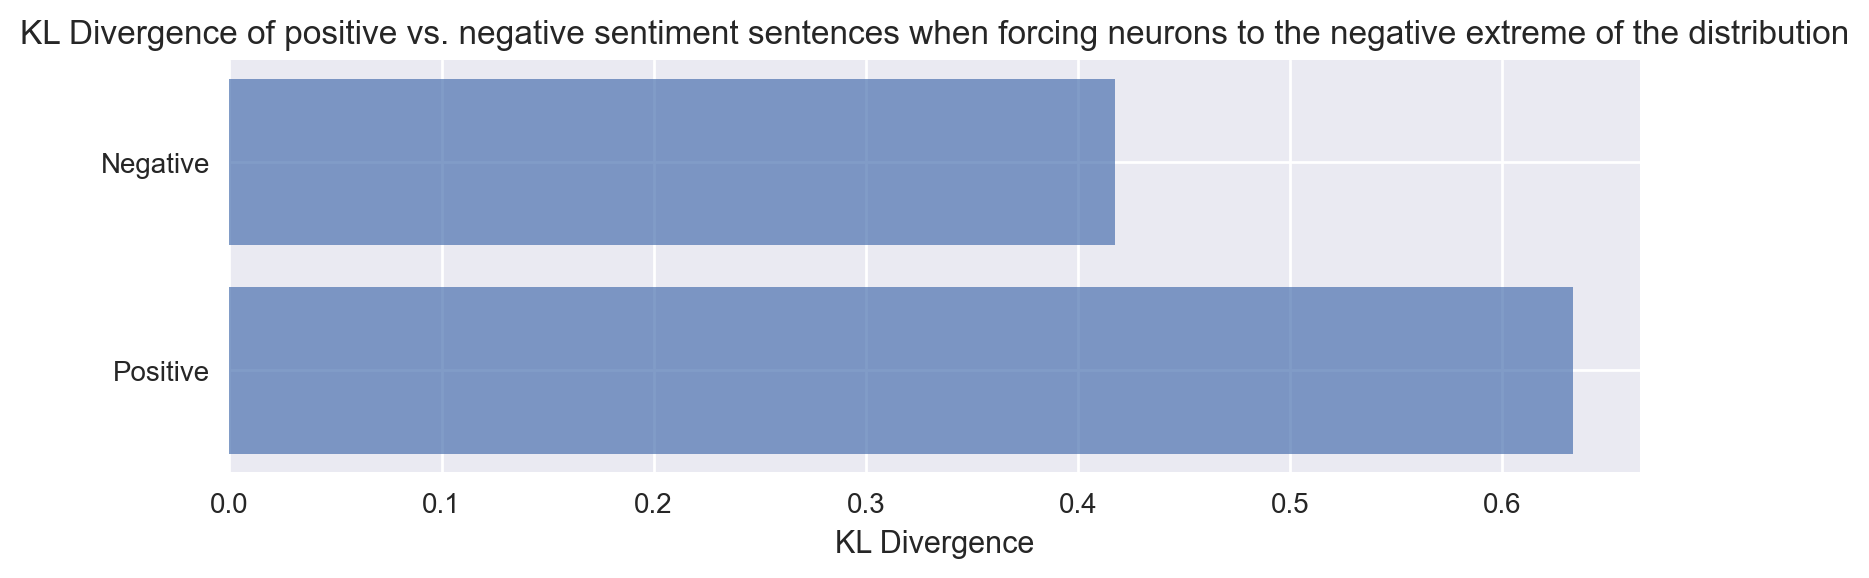

In [26]:
widths = [np.mean(pos_divs), np.mean(neg_divs)]

plt.figure(figsize=(8,3))
plt.barh(['Positive', 'Negative'], widths, alpha=0.7)

plt.xlabel('KL Divergence')
plt.title('KL Divergence of positive vs. negative sentiment sentences when forcing neurons to the negative extreme of the distribution')

plt.tight_layout()
plt.show()

# Sentiment Analysis

In [1]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [2]:
df = pd.read_csv('output/generated_sentences.csv')

NameError: name 'pd' is not defined

In [27]:
altered_mask = df.label == 1
normal_mask = df.label == 0

In [28]:
altered_results = classifier(df[altered_mask].sentence.to_list())
normal_results = classifier(df[normal_mask].sentence.to_list())

In [29]:
scores = [result['score'] for result in normal_results + altered_results]
sentiments = [result['label'] for result in normal_results + altered_results]

In [30]:
df['score'] = scores
df['sentiment'] = sentiments

In [31]:
df[altered_mask].sentiment.value_counts()

NEGATIVE    950
POSITIVE     50
Name: sentiment, dtype: int64

In [32]:
df[normal_mask].sentiment.value_counts()

POSITIVE    650
NEGATIVE    350
Name: sentiment, dtype: int64

In [43]:
df[altered_mask].sample().sentence.iloc[0]

"I watched a new movie yesterday. I thought it was boring, and it even, I must repeat, I'm not even saying a little bit of"